In [16]:
import s3torchconnector

import boto3
import botocore
import io
import itertools
from PIL import Image
import torch
import torchdata
import torchvision
import webdataset
import matplotlib.pyplot as plt

In [17]:
S3_IMAGES_URI = "s3://tractable-images-narwhal-anonymised/"

REGION = "us-east-1"


In [41]:
def load_image(object):
    img = Image.open(object)
    # resize the image to 384x384, so we can batch the images at once
    img = img.resize((384, 384))
    # Convert to tensor and normalize to float [0, 1]
    tensor = torchvision.transforms.functional.pil_to_tensor(img).float() / 255.0
    return (object.key, tensor)


## Using S3IterableDataset

For better performance when you don't need random access, consider using `S3IterableDataset` which doesn't require enumerating all objects upfront:


Testing with S3IterableDataset:
Batch 0: 4 images
Image shapes: torch.Size([4, 3, 384, 384])
Keys: ('00000026-107e-502f-a0de-58e7d49ee9d8.jpg', '0000016b-fa14-5bf2-b61c-bd71214d7f7d.jpg')...


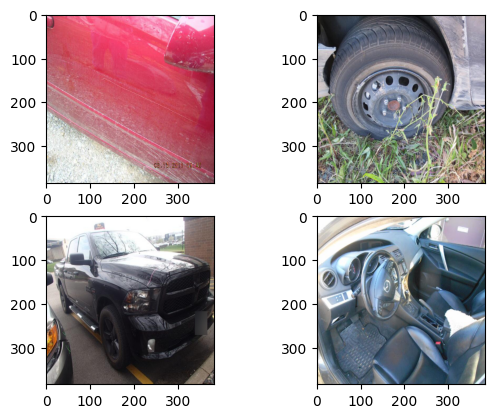

In [42]:
# Alternative approach: Use S3IterableDataset for streaming without enumeration
iterable_dataset_direct = s3torchconnector.S3IterableDataset.from_prefix(
    S3_IMAGES_URI, 
    region=REGION, 
    transform=load_image, 
    enable_sharding=False,
    
)

# This will be much faster as it doesn't enumerate all objects
iterable_loader = torch.utils.data.DataLoader(iterable_dataset_direct, batch_size=4, num_workers=4, prefetch_factor=4)

# Test with a few batches
print("Testing with S3IterableDataset:")
for i, (keys, images) in enumerate(itertools.islice(iterable_loader, 50)):
    print(f"Batch {i}: {len(keys)} images")
    print(f"Image shapes: {images.shape}")
    print(f"Keys: {keys[:2]}...")  # Show first 2 keys
    if i == 0:
        plt.subplot(2,2,1)
        plt.imshow(images[0].permute(1, 2, 0))
        plt.subplot(2,2,2)
        plt.imshow(images[1].permute(1, 2, 0))
        plt.subplot(2,2,3)
        plt.imshow(images[2].permute(1, 2, 0))
        plt.subplot(2,2,4)
        plt.imshow(images[3].permute(1, 2, 0))
        plt.show()
        break
    if i >= 5:  # Stop after 2 batches
        break


In [43]:
# Method 3: Check loader properties and dataset info
print("\\nMethod 3: Loader and dataset properties:")
print("-" * 45)

print(f"DataLoader properties:")
print(f"  - Batch size: {iterable_loader.batch_size}")
print(f"  - Number of workers: {iterable_loader.num_workers}")
print(f"  - Pin memory: {iterable_loader.pin_memory}")

# Check if we can get dataset info
try:
    dataset = iterable_loader.dataset
    print(f"\\nDataset properties:")
    print(f"  - Dataset type: {type(dataset).__name__}")
            
except Exception as e:
    print(f"Could not access dataset properties: {e}")


\nMethod 3: Loader and dataset properties:
---------------------------------------------
DataLoader properties:
  - Batch size: 4
  - Number of workers: 4
  - Pin memory: False
\nDataset properties:
  - Dataset type: S3IterableDataset


### Try training a simple cnn model on the images

In [44]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        
        # Calculate the size after conv layers: 384 -> 192 -> 96 -> 48
        self.fc1 = nn.Linear(128 * 48 * 48, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Conv layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))  # 384x384 -> 192x192 ?
        x = self.pool(F.relu(self.conv2(x)))  # 192x192 -> 96x96 ?
        x = self.pool(F.relu(self.conv3(x)))  # 96x96 -> 48x48 ?
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Initialize the model
model = SimpleCNN(num_classes=10)  # Assuming 10 classes for classification
print(f"Model architecture:\\n{model}")

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\\nUsing device: {device}")
model = model.to(device)


Model architecture:\nSimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=294912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
\nUsing device: cuda


In [45]:
# Training configuration
learning_rate = 0.001
num_epochs = 3
batch_size = 4

# Since I don't have labels, created dummy labels for demonstration
def create_dummy_labels(batch_size):
    """Create dummy labels for demonstration purposes"""
    return torch.randint(0, 10, (batch_size,))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training configuration:")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Number of epochs: {num_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Optimizer: Adam")
print(f"  - Loss function: CrossEntropyLoss")
print(f"\\nNote: Using dummy labels for demonstration. In practice, you'd have real labels.")


Training configuration:
  - Learning rate: 0.001
  - Number of epochs: 3
  - Batch size: 4
  - Optimizer: Adam
  - Loss function: CrossEntropyLoss
\nNote: Using dummy labels for demonstration. In practice, you'd have real labels.


In [52]:
print("Starting training...")
print("=" * 50)

total_batches_processed = 0
epoch_losses = []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    batch_count = 0
    
    print(f"\\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)
    
    for batch_idx, (keys, images) in enumerate(itertools.islice(iterable_loader, 20)):  # Limit to 20 batches per epoch for demo
        if images.dtype == torch.uint8:
            images = images.float() / 255.0
        images = images.to(device)
        
        labels = create_dummy_labels(images.size(0)).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Backprop the loss
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        batch_count += 1
        total_batches_processed += 1
        
        if (batch_idx + 1) % 5 == 0:
            avg_loss = running_loss / batch_count
            print(f"  Batch {batch_idx + 1}/20 | Loss: {loss.item():.4f} | Avg Loss: {avg_loss:.4f}")
    
    # Calculate epoch average loss
    epoch_avg_loss = running_loss / batch_count if batch_count > 0 else 0
    epoch_losses.append(epoch_avg_loss)
    
    print(f"  Epoch {epoch + 1} completed | Average Loss: {epoch_avg_loss:.4f}")

print("\\n" + "=" * 50)
print("Training completed!")
print(f"Total batches processed: {total_batches_processed}")
print(f"Final average loss: {epoch_losses[-1]:.4f}")


Starting training...
\nEpoch 1/3
------------------------------
  Batch 5/20 | Loss: 2.2816 | Avg Loss: 2.3062
  Batch 10/20 | Loss: 2.3094 | Avg Loss: 2.3018
  Batch 15/20 | Loss: 2.3132 | Avg Loss: 2.3019
  Batch 20/20 | Loss: 2.3042 | Avg Loss: 2.3038
  Epoch 1 completed | Average Loss: 2.3038
\nEpoch 2/3
------------------------------
  Batch 5/20 | Loss: 2.3308 | Avg Loss: 2.3008
  Batch 10/20 | Loss: 2.3407 | Avg Loss: 2.3132
  Batch 15/20 | Loss: 2.3273 | Avg Loss: 2.3161
  Batch 20/20 | Loss: 2.2904 | Avg Loss: 2.3131
  Epoch 2 completed | Average Loss: 2.3131
\nEpoch 3/3
------------------------------
  Batch 5/20 | Loss: 2.2904 | Avg Loss: 2.2924
  Batch 10/20 | Loss: 2.3127 | Avg Loss: 2.2971
  Batch 15/20 | Loss: 2.3081 | Avg Loss: 2.2988
  Batch 20/20 | Loss: 2.3152 | Avg Loss: 2.3001
  Epoch 3 completed | Average Loss: 2.3001
\n==================================================
Training completed!
Total batches processed: 60
Final average loss: 2.3001


\nModel Inference Test:
Batch size: 4
Image shape: torch.Size([4, 3, 384, 384])
Predictions: [7 7 7 7]
Prediction probabilities (first image): [0.10420654 0.09518123 0.09999316 0.10062982 0.10451683 0.0981484
 0.09957215 0.10559501 0.09816181 0.09399509]


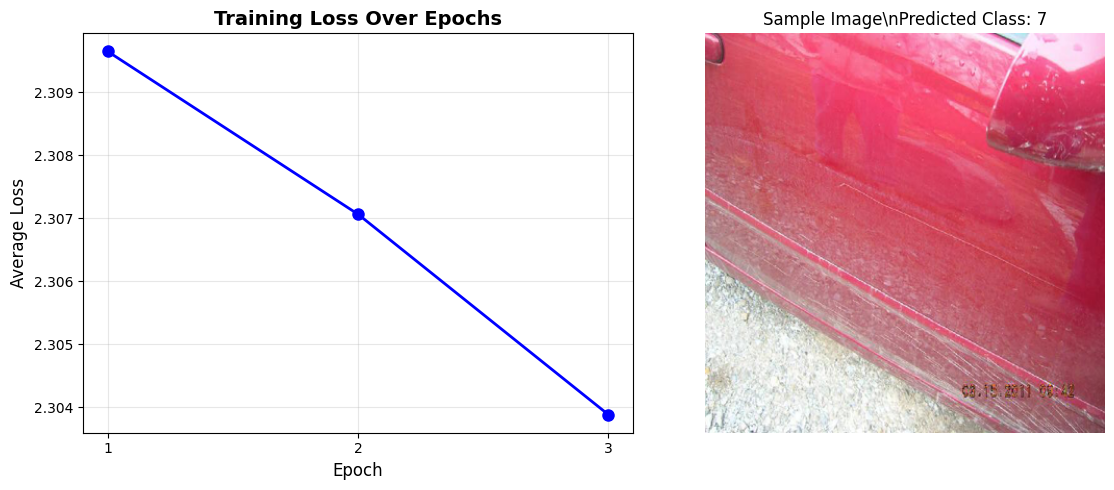

\nTraining Summary:
Model: Simple CNN with 151155658 parameters
Training completed over 3 epochs
Final loss: 2.3039
Model is ready for inference on new images from S3!


In [51]:
# Below is a vibecoded setup !

# Visualize training progress and test the trained model
# Initialize variables if not defined (for linter compatibility)
if 'epoch_losses' not in locals():
    epoch_losses = []

plt.figure(figsize=(12, 5))

# Plot training loss (check if epoch_losses exists from previous training)
if 'epoch_losses' in locals() and len(epoch_losses) > 0:
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'b-o', linewidth=2, markersize=8)
    plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, len(epoch_losses) + 1))
else:
    plt.subplot(1, 2, 1)
    plt.text(0.5, 0.5, 'No training data available\\nRun training cell first', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Training Loss', fontsize=14)

# Test the model on a sample batch
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Get a test batch
    test_batch = next(iter(itertools.islice(iterable_loader, 1)))
    test_keys, test_images = test_batch
    # Convert images to float if they're not already
    if test_images.dtype == torch.uint8:
        test_images = test_images.float() / 255.0
    test_images = test_images.to(device)
    
    # Get predictions
    test_outputs = model(test_images)
    test_predictions = torch.argmax(test_outputs, dim=1)
    
    print(f"\\nModel Inference Test:")
    print(f"Batch size: {test_images.size(0)}")
    print(f"Image shape: {test_images.shape}")
    print(f"Predictions: {test_predictions.cpu().numpy()}")
    print(f"Prediction probabilities (first image): {torch.softmax(test_outputs[0], dim=0).cpu().numpy()}")
    
    # Display a test image with prediction
    plt.subplot(1, 2, 2)
    test_image = test_images[0].cpu().permute(1, 2, 0)
    plt.imshow(test_image)
    plt.title(f'Sample Image\\nPredicted Class: {test_predictions[0].item()}', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\\nTraining Summary:")
if 'model' in locals():
    print(f"Model: Simple CNN with {sum(p.numel() for p in model.parameters())} parameters")
if 'num_epochs' in locals():
    print(f"Training completed over {num_epochs} epochs")
if 'epoch_losses' in locals() and len(epoch_losses) > 0:
    print(f"Final loss: {epoch_losses[-1]:.4f}")
    print(f"Model is ready for inference on new images from S3!")
else:
    print("Run the training cells first to see training results.")
